# Functions

**Generate the B graph**

In [63]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import random
from sklearn.metrics import f1_score
from time import time
import matplotlib.pyplot as plt
from numpy.ma.extras import average
from sklearn.metrics import confusion_matrix
from numpy.linalg import slogdet

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcdefaults()

### Data Generation Functions

In [102]:
def B_mat_symmetric(a, p):
    '''To generate a symmetric toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/super-diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
        np.fill_diagonal(result[:,i:], -1*a[i]) # Super-diagonals
    return result


def B_mat_lowertriangular(a, p):
    '''To generate a lower triangular toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
    return result


def cov_x(p):
    """ Generate the covariance matrix for x"""
    sigma_x = np.eye(p)
    return sigma_x


def cov_y(sigma_x, B):
    """ Generate covariance matrix for Y i.e. (B^(-1).X.B^(-T)) since Y=B^(-1).X"""
    B_inv = np.linalg.solve(B, np.eye(B.shape[0]))
    sigma_y = B_inv@sigma_x@B_inv.T
    return sigma_y


def generate_y(mean_y, sigma_y, n_samples):
    """ Generate samples of Y"""
    y_samples = multivariate_normal.rvs(mean=mean_y, cov=sigma_y, size=n_samples)
    return y_samples
    
    
def samp_cov(y_samples):
    """ Generating sample covariance matrix """
    n_samples = len(y_samples)
    samp_cov_y = np.sum(np.array([np.outer(y_samples[i],y_samples[i]) for i in range(n_samples)]), axis=0)/n_samples 
    return samp_cov_y


def soft(x, y):
    return np.sign(x) * np.maximum(np.abs(x) - y, 0)


def threshold(vec, threshold_value=0.002):
    vec1 = vec.copy()
    vec1[np.abs(vec) < threshold_value] = 0
    return vec1


def binarize_matrix(matrix):
    '''Converts non-zero elements to 1 and keeps zeros as zeros.'''
    binary_matrix = np.where(matrix != 0, 1, 0)
    return binary_matrix


def compute_recovery_rate_numpy(a_binary, true_a_binary):
    joint_ones = np.sum((a_binary == 1) & (true_a_binary == 1)) # True positives + False positives
    ones_true_a = np.sum(true_a_binary == 1) # True positives
    if ones_true_a == 0:
        return 0
    return joint_ones / ones_true_a


def create_sparse_vec_pos_def_2(dim, nonzeros, diag=20):
    ''' Function to create sparse vector(p x 1) which can generate symmetric +ve definite toeplitz matrix'''
    vec = np.zeros((dim,))
    vec[0] = diag
    nonzeros -= 1
    # selection of indicies with the non-zero entry (random selection)
    non_zero_indices = random.sample(range(1,dim),nonzeros)
    for idx in non_zero_indices:
        # Randomly assign values to non-zero entries 
        vec[idx] = random.randint(1,5)
    return vec


### Different functions for ADMM ###

# def f1(a, S, sigma_x, rho, a2, mu1, regularized = False):
#     """ Function evaluation for Newton method with regularization term based on ADMM
#         Tr[S.Theta_y] - logdet(Theta_y) + rho/2*||a1 - a2 + mu1||_1"""
#     p = S.shape[0]
#     a.reshape((-1,))
#     B = B_mat_symmetric(a, p)
#     theta_x = np.linalg.solve(sigma_x, np.eye(p))
#     if regularized:
#         # Added [1:] since we don't want to regularize a0
#         reg_term = 0.5*rho * np.linalg.norm(a[1:] - a2 + mu1)**2
#     else:
#         reg_term = 0
#     return np.trace(S@B.T@theta_x@B)-np.log(np.linalg.det(B.T@theta_x@B))+reg_term 


def f2(a, lam):
    """ Function evaluation of regularization term """
    return lam*np.linalg.norm(a[1:],1)
    
    
def f(a, S, sigma_x):
    a.reshape((-1,))
    B = B_mat_symmetric(a, S.shape[0])
    sigma_x_inv = np.linalg.solve(sigma_x, np.eye(S.shape[0]))
    return np.trace(S@B.T@sigma_x_inv@B) - np.log(np.linalg.det(B.T@sigma_x_inv@B))

Metrics

In [103]:
def kll(a, a_hat, sigma_x):
    ''' Computing the KL loss for the covariance matrices of Y'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    return np.trace(sigma_y@theta_y_hat) - np.log(np.linalg.det(sigma_y@theta_y_hat)) - p

def rkll(a, a_hat, sigma_x):
    ''' Computing the reverse KL loss for the covariance matrices of Y'''
    return kll(a_hat, a, sigma_x)

def rte(a, a_hat, sigma_x):
    ''' Computing the relative trace error loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    return abs(1 - (np.trace(theta_y_hat)/np.trace(theta_y)))

def norm_loss(a, a_hat, sigma_x):
    ''' Computing the norm loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    fro = np.linalg.norm(theta_y-theta_y_hat,ord='fro')
    spe = np.linalg.norm(theta_y-theta_y_hat,ord=2)
    l1 = np.linalg.norm(theta_y-theta_y_hat,ord=1)
    return fro, spe, l1

def scores(a, a_hat, threshold_value):
    ''' Computing the support recovery based scores for the precision matrix'''
    a_thr = threshold(a_hat, threshold_value=threshold_value) # Apply the threshold
    a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
    true_a_binary = binarize_matrix(a)  # True Support Vector
    cm = confusion_matrix(true_a_binary, a_binary)
    tn,fp,fn,tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    accuracy = (tn + tp)/np.sum(cm)
    specificity = (tn)/(tn + fp) # TN/(TN+FP)
    sensitivity = (tp)/(tp + fn) # TP/(TP+FN)
    MCC = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return accuracy, specificity, sensitivity, MCC, cm

Caching T matrix 

In [104]:
def make_T_matrices(p, symmetric=False):
    """
    Returns a list [T0, T1, …, T(p-1)] of pxp matrices
    """
    T = []
    I = np.eye(p)
    T.append(I)
    for j in range(1, p):
        M = np.zeros((p,p))
        if symmetric:
            M[np.arange(j,p), np.arange(0,p-j)] = -1   # sub
            M[np.arange(0,p-j), np.arange(j,p)] = -1   # super
        else:
            M[np.arange(j,p), np.arange(0,p-j)] = -1   # only sub
        T.append(M)
    return T

def build_B(a, T_list):
    """Construct B given a list of T matrices"""
    B = sum( a[j]*T_list[j] for j in range(len(a)) )
    return B

def Theta(a, T_list, Sigma_x_inv):
    B = build_B(a, T_list)
    return B @ Sigma_x_inv @ B.T

def f1(a, S, T_list, Sigma_x_inv):
    Th = Theta(a, T_list, Sigma_x_inv)
    tr = np.trace(S @ Th)
    _, logdet = slogdet(Th)
    return tr - logdet     # Eq. (16)

def grad_f1(a, S, T_list, Sigma_x_inv):
    p = len(a)
    B = build_B(a, T_list)
    B_inv = np.linalg.solve(B, np.eye(p))
    BSi = B @ Sigma_x_inv
    g = np.zeros(p)
    for i in range(p):
        Ti = T_list[i]
        # TODO: check if its exactly as EQ 20 - 22
        g[i] = 2*( np.trace(S @ BSi @ Ti) - np.trace(B_inv @ Ti) )
    return g

def hess_f1(a, S, T_list, Sigma_x_inv):
    p = len(a)
    B = build_B(a, T_list)
    B_inv = np.linalg.solve(B, np.eye(p))
    H = np.zeros((p,p))
    for i in range(p):
        Ti = T_list[i]
        for j in range(p):
            Tj = T_list[j]
            # TODO: check if its exactly as EQ 21 - 23
            term1 = np.trace(Sigma_x_inv @ Tj @ S @ Ti)
            term2 = np.trace(B_inv @ Tj @ B_inv @ Ti)
            H[i,j] = 2*(term1 + term2)
    return H

In [105]:
def newton_subproblem(a0, S, T_list, Sigma_x_inv, rho, v, 
                      tol=1e-4, alpha=0.5, beta=0.7, max_iter=50):
    a = a0.copy()
    p = len(a)
    for k in range(max_iter):
        # gradient of f1 + gradient of (rho/2)||a1:-v||^2
        g = grad_f1(a, S, T_list, Sigma_x_inv)
        g[1:] += rho*(a[1:] - v)
        # Hessian of f1 + rho*I on block 1:
        H = hess_f1(a, S, T_list, Sigma_x_inv)
        H[1:,1:] += rho*np.eye(p-1)

        # Newton step & decrement
        delta = -np.linalg.solve(H, g)
        lam2 = g @ (-delta)
        if lam2/2 <= tol:
            break

        if(k%10==1):
            print(f"Newton iteration {k}, lam^2/2: {lam2/2:.2e} - Tol: {tol} ")

        # backtracking + PSD check
        t = 1.0
        while True:
            a_new = a + t*delta
            B_new = build_B(a_new, T_list)
            if np.min(np.linalg.eigvalsh(B_new)) > 0:
                break
            t *= beta
        # Armijo
        while (f1(a_new, S, T_list, Sigma_x_inv)
               + 0.5*rho*np.linalg.norm(a_new[1:]-v)**2
               > f1(a, S, T_list, Sigma_x_inv)
               + 0.5*rho*np.linalg.norm(a[1:]-v)**2
               + alpha*t*(g @ delta)):
            t *= beta
            a_new = a + t*delta

        a = a_new
    return a


In [106]:
def admm_toeplitz(S, sigma_x, p, lam, rho, max_iters=100, tol=1e-4,
                  symmetric=False):
    # pick the right T_list & Sigma_x_inv
    Sigma_x_inv = np.linalg.solve(sigma_x, np.eye(p))
    T_list = make_T_matrices(p, symmetric=symmetric)

    # initialize
    a1 = np.ones(p)             
    a2 = np.zeros(p-1)
    mu = np.zeros(p-1)

    for k in range(max_iters):
        # Newton subproblem
        a1 = newton_subproblem(a1, S, T_list, Sigma_x_inv,
                               rho, a2 - mu)

        # soft‑threshold on a1[1:]
        z = a1[1:] + mu
        a2 = np.sign(z)*np.maximum(np.abs(z) - lam/rho, 0.0)

        # dual update
        mu += a1[1:] - a2

        # convergence
        r_norm = np.linalg.norm(a1[1:] - a2) # primal residual
        s_norm = np.linalg.norm(rho*(a2 - (a1[1:]-mu)))  # dual residual
        if(k%10==0):
            print(f"ADMM iteration {k}, primal residual: {r_norm:.2e} Dual residual: {s_norm:.2e}")
        if r_norm < tol and s_norm < tol:
            print(f"ADMM converged at iter {k}")
            break

    return a1


Finding the best lambda, rho for different p – [25, 50, 75, 100, 200]

In [107]:
import itertools

In [108]:
class SolverArgs:
    def __init__(self,
                 p: int = 50,
                 d: int = 5,
                 const: float = 15,
                 rho: float = 0.1,
                 lambda_param: float = 0.05,
                 num_rep: int = 1,
                 max_admm_iters: int = 40,
                 admm_tol: float = 1e-3,
                 symmetric: bool = False  
                ):
        self.p            = p
        self.d            = d
        self.const        = const
        self.rho          = rho
        self.lambda_param = lambda_param
        self.num_rep      = num_rep
        self.max_admm_iters = max_admm_iters
        self.admm_tol     = admm_tol
        self.symmetric    = symmetric


In [109]:
class Solver:
    def __init__(self, args: SolverArgs):
        self.args = args
        
    def solve(self):
            args = self.args
            p, d = args.p, args.d
            rho, lam = args.rho, args.lambda_param
            reps = args.num_rep

            # precompute T_list once per solve
            T_list = make_T_matrices(p, symmetric=args.symmetric)

            data = {}
            for rep in range(reps):
                a_true = create_sparse_vec_pos_def_2(p, d, diag=d*10)
                B0     = build_B(a_true, T_list)
                sigma_x = np.eye(p)
                sigma_y = np.linalg.solve(B0, np.eye(p)) @ sigma_x @ np.linalg.solve(B0, np.eye(p)).T
                Y       = multivariate_normal.rvs(mean=np.zeros(p), cov=sigma_y, size=int(args.const*d*np.log(p)))
                S       = samp_cov(Y)

                a_est = admm_toeplitz(
                    S           = S,
                    sigma_x     = sigma_x,
                    p           = p,
                    lam         = lam,
                    rho         = rho,
                    max_iters   = args.max_admm_iters,
                    tol         = args.admm_tol,
                    symmetric   = args.symmetric
                )

                data[rep] = {
                    'a_true': a_true,
                    'a_est' : a_est,
                    'S'     : S,
                    'sigma_x': sigma_x
                }

            return data
    
    def evaluate(self, data):
        num_rep = self.args.num_rep
        keys = list(data[0].keys())
        threshold_range = 0.01 * np.arange(101)

        best_thr = []
        best_rate = []
        best_acc = []
        best_f1 = []
        best_cm = []

        kll_const = []
        rkll_const = []
        rte_const = []
        norm_const = []
        scores_const = []

        for rep in range(num_rep):
            a = data[rep][keys[7]]
            a1 = data[rep][keys[-4]]
            sigma_x = data[rep][keys[-1]]
            true_a_binary = binarize_matrix(a)
            thr_rate = []
            thr_cm = []
            thr_acc = []
            thr_f1 = []

            for thr in threshold_range:
                a_thr = threshold(a1, threshold_value=thr)
                a_binary = binarize_matrix(a_thr)
                rate = compute_recovery_rate_numpy(a_binary, true_a_binary)
                cm = confusion_matrix(true_a_binary, a_binary)
                accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)

                thr_rate.append(rate)
                thr_cm.append(cm)
                thr_acc.append(accuracy)
                thr_f1.append(f1_score(true_a_binary, a_binary))

            idx = np.argmax(np.array(thr_acc))
            best_thr.append(threshold_range[idx])
            best_rate.append(thr_rate[idx])
            best_acc.append(thr_acc[idx])
            best_f1.append(thr_f1[idx])
            best_cm.append(thr_cm[idx])

            a_thr = threshold(a1, threshold_value=threshold_range[idx])
            a_binary = binarize_matrix(a_thr)

            kll_const.append(kll(a, a_thr, sigma_x))
            rkll_const.append(rkll(a, a_thr, sigma_x))
            rte_const.append(rte(a, a_thr, sigma_x))
            norm_const.append(norm_loss(a, a_thr, sigma_x))
            scores_const.append(scores(a, a1, threshold_value=threshold_range[idx]))

        metrics = {
            'avg_acc': average(best_acc),
            'avg_f1': average(best_f1),
            'avg_rate': average(best_rate),
            'avg_kll': average(kll_const),
            'avg_rkll': average(rkll_const),
            'avg_rte': average(rte_const),
            'avg_fro': average([n[0] for n in norm_const]),
            'avg_spec': average([n[1] for n in norm_const]),
            'avg_l1': average([n[2] for n in norm_const])
        }

        return metrics

In [110]:
defaultArgs = SolverArgs()
defaultSolver = Solver(defaultArgs)
temp = defaultSolver.solve()

Newton iteration 1, lam^2/2: 4.98e+01 - Tol: 0.0001 
ADMM iteration 0, primal residual: 1.17e+00 Dual residual: 0.00e+00
Newton iteration 1, lam^2/2: 3.59e-02 - Tol: 0.0001 
Newton iteration 11, lam^2/2: 3.59e-02 - Tol: 0.0001 
Newton iteration 21, lam^2/2: 3.59e-02 - Tol: 0.0001 
Newton iteration 31, lam^2/2: 3.59e-02 - Tol: 0.0001 
Newton iteration 41, lam^2/2: 3.59e-02 - Tol: 0.0001 
Newton iteration 1, lam^2/2: 3.60e-02 - Tol: 0.0001 
Newton iteration 11, lam^2/2: 3.60e-02 - Tol: 0.0001 
Newton iteration 21, lam^2/2: 3.60e-02 - Tol: 0.0001 
Newton iteration 31, lam^2/2: 3.60e-02 - Tol: 0.0001 
Newton iteration 41, lam^2/2: 3.60e-02 - Tol: 0.0001 
Newton iteration 1, lam^2/2: 3.62e-02 - Tol: 0.0001 
Newton iteration 11, lam^2/2: 3.62e-02 - Tol: 0.0001 
Newton iteration 21, lam^2/2: 3.62e-02 - Tol: 0.0001 
Newton iteration 31, lam^2/2: 3.62e-02 - Tol: 0.0001 
Newton iteration 41, lam^2/2: 3.62e-02 - Tol: 0.0001 
Newton iteration 1, lam^2/2: 3.64e-02 - Tol: 0.0001 
Newton iteration 11

In [94]:
def evaluate(data):
        num_rep = len(data)
        threshold_range = 0.01 * np.arange(101)

        best_thr = []
        best_rate = []
        best_acc = []
        best_f1 = []
        best_cm = []

        kll_const = []
        rkll_const = []
        rte_const = []
        norm_const = []
        scores_const = []

        for rep in range(num_rep):
            a = data[rep]['a_true']
            a1 = data[rep]['a_est']
            sigma_x = data[rep]['sigma_x']
            true_a_binary = binarize_matrix(a)
            thr_rate = []
            thr_cm = []
            thr_acc = []
            thr_f1 = []

            for thr in threshold_range:
                a_thr = threshold(a1, threshold_value=thr)
                a_binary = binarize_matrix(a_thr)
                rate = compute_recovery_rate_numpy(a_binary, true_a_binary)
                cm = confusion_matrix(true_a_binary, a_binary)
                accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)

                thr_rate.append(rate)
                thr_cm.append(cm)
                thr_acc.append(accuracy)
                thr_f1.append(f1_score(true_a_binary, a_binary))

            idx = np.argmax(np.array(thr_acc))
            best_thr.append(threshold_range[idx])
            best_rate.append(thr_rate[idx])
            best_acc.append(thr_acc[idx])
            best_f1.append(thr_f1[idx])
            best_cm.append(thr_cm[idx])

            a_thr = threshold(a1, threshold_value=threshold_range[idx])
            a_binary = binarize_matrix(a_thr)

            kll_const.append(kll(a, a_thr, sigma_x))
            rkll_const.append(rkll(a, a_thr, sigma_x))
            rte_const.append(rte(a, a_thr, sigma_x))
            norm_const.append(norm_loss(a, a_thr, sigma_x))
            scores_const.append(scores(a, a1, threshold_value=threshold_range[idx]))

        metrics = {
            'avg_acc': average(best_acc),
            'avg_f1': average(best_f1),
            'avg_rate': average(best_rate),
            'avg_kll': average(kll_const),
            'avg_rkll': average(rkll_const),
            'avg_rte': average(rte_const),
            'avg_fro': average([n[0] for n in norm_const]),
            'avg_spec': average([n[1] for n in norm_const]),
            'avg_l1': average([n[2] for n in norm_const])
        }

        return metrics

In [95]:
evaluate(temp)

{'avg_acc': 0.92,
 'avg_f1': 0.6666666666666666,
 'avg_rate': 0.8,
 'avg_kll': 2.1475955645315707,
 'avg_rkll': 1.6757317040093653,
 'avg_rte': 0.01486932719641465,
 'avg_fro': 4574.5773449975,
 'avg_spec': 1605.9896120839842,
 'avg_l1': 2705.3665237585496}

In [56]:
import csv

In [57]:
p_values = [25, 50, 75]
lambda_grid = [0.01, 0.05, 0.1, 0.2]
rho_grid = [0.5, 1.0, 2.0]

results = []

for p in p_values:
    best_loss = float('inf')
    best_params = None

    for lamb, rho in itertools.product(lambda_grid, rho_grid):
        args = SolverArgs(p=p, lambda_param=lamb, rho=rho, num_rep=2, )
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)

        result_row = {
            'p': p,
            'lambda': lamb,
            'rho': rho,
            **metrics
        }
        results.append(result_row)

        if metrics['avg_kll'] < best_loss:
            best_loss = metrics['avg_kll']
            best_params = result_row

    print(f"Best for p={p}:", best_params)

# Save to CSV
with open('grid_search_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print("Results saved to 'grid_search_results.csv'")


Dimensions of Matrix =  25 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
124943.88362868474 [ 9.99103059e-01 -4.23117963e-05  1.88299203e-05  6.98905668e-06
 -3.61115384e-05  4.18706530e-05  4.87724705e-06 -7.03028402e-06
 -3.36815444e-05  2.20598025e-04  1.30506327e-05  3.43615217e-05
  8.58261960e-06 -2.55201995e-05  4.86465500e-05  3.85267077e-05
  2.20060164e-05  9.08461060e-06  2.21315659e-04 -3.66952348e-05
  1.73805760e-04  6.64115951e-05 -1.42131835e-04  6.30317280e-05
  1.13918858e-04]
0
line search
line search
line search
line search
line search
line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
ADMM iter  0: primal=7.98e-02, dual=3.36e-01
================================================== i

In [46]:
# Save to CSV
with open('grid_search_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print("Results saved to 'grid_search_results.csv'")

Results saved to 'grid_search_results.csv'


Sparsity vs F1

Dimensions of Matrix =  25 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
124942.61721856629 [ 9.99082875e-01  2.08758550e-05  1.45168008e-05  2.22936510e-04
  3.23547904e-05 -6.95606117e-06  2.04655420e-04  1.19440949e-04
  6.95178593e-06  7.71746637e-05  4.62844369e-05  1.22359375e-05
  3.37314227e-05  1.54785541e-05  2.37133662e-05  1.95211847e-05
  3.17532375e-05  2.10489205e-05  1.88792274e-05 -3.55135712e-05
  5.65004624e-05  3.81894859e-05  2.75169605e-05  1.97844112e-04
  2.37138863e-05]
0
line search
line search
line search
line search
line search
line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 =================================

C:\Users\rohit\AppData\Local\Temp\ipykernel_24492\901135652.py:49: RuntimeWarning: invalid value encountered in scalar divide
  specificity = (tn)/(tn + fp) # TN/(TN+FP)
C:\Users\rohit\AppData\Local\Temp\ipykernel_24492\901135652.py:51: RuntimeWarning: invalid value encountered in scalar divide
  MCC = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


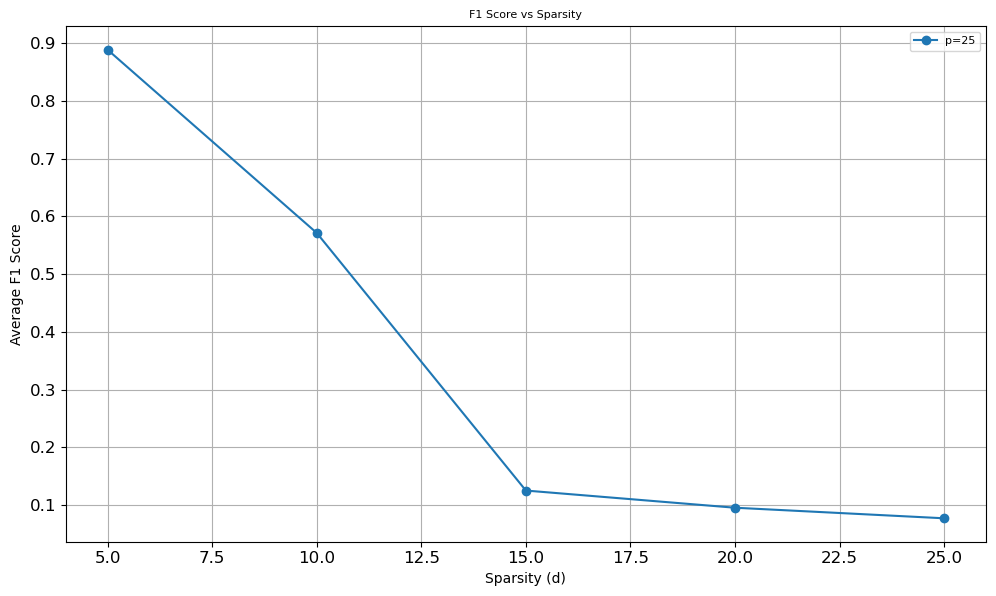

In [44]:
p_list = [25]
d_list = [5, 10, 15, 20, 25]
lambda_val = 0.05
rho_val = 0.5

f1_results = {p: [] for p in p_list}

for p in p_list:
    for d in d_list:
        args = SolverArgs(p=p, d=d, lambda_param=lambda_val, rho=rho_val, num_rep=1)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        f1_results[p].append(metrics['avg_f1'])

# Plotting
plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(d_list, f1_results[p], marker='o', label=f'p={p}')

plt.xlabel('Sparsity (d)')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs Sparsity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tau vs F1

In [ ]:
p_list = [25]
tau = [0.5, 1, 2, 3, 10, 50, 100]
d_fixed = 10
lambda_val = 0.05
rho_val = 1
np.random.seed(0)

f1_results_ratio = {p: [] for p in p_list}

for p in p_list:
    for t in tau:
        args = SolverArgs(p=p, d=d_fixed, const=t, lambda_param=lambda_val, rho=rho_val, num_rep=5)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        f1_results_ratio[p].append(metrics['avg_f1'])

plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(tau, f1_results_ratio[p], marker='o', label=f'p={p}')

plt.xlabel(r"$\tau = N/(d^2 \log p)$")
plt.ylabel('Average F1 Score')
plt.title(r'F1 Score vs $\tau$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Dimensions of Matrix =  25 Sparsity =  10
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
124987.35797229888 [ 9.99797772e-01  1.53511618e-05  2.37468072e-05  1.68331754e-05
  1.53879133e-06  8.73646525e-06 -1.25426882e-05  1.03556385e-06
  2.79151668e-07  2.47410948e-06 -9.39346914e-07 -7.55274919e-06
  2.23474645e-05 -1.00233289e-06  7.14466377e-06 -1.90387386e-05
  1.15725736e-05  2.43442270e-05  2.00828834e-05 -4.55055053e-06
  6.84932258e-06  3.10737762e-05 -3.43217162e-05 -1.00586454e-05
 -2.35580435e-05]
0
line search
line search
line search
line search
line search
line search
line search
line search
line search
line search
0.004953512106214143 [ 3.43342120e-03  2.49551401e-06  3.71340666e-06  2.51727525e-06
  2.06357248e-07  1.18492586e-06 -4.73318149e-02  1.20802

In [ ]:
plt.spy(B_mat_symmetric(, 25))